In [1]:
import xarray as xr
import gsw
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cmocean
import pandas as pd

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config["data_dir"] = '/home1/datahome/epauthen/cartopy_shapefiles'
from numba import float64, guvectorize

pathfig = '/home1/datawork/epauthen/Fig_Product/All_depth/'
path_model = "/home/datawork-lops-bluecloud/osnet/models/all_depth"

In [2]:
proj=ccrs.PlateCarree()
land_feature = cfeature.NaturalEarthFeature(
category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
extent = np.array([-80, -30, 23, 47.5])
subplot_kw = {'projection': proj, 'extent': extent}

In [3]:
ds = xr.open_dataset("/home/datawork-lops-bluecloud/osnet/data_out/PRED_alldepth_bathy500_full.nc")
ds = ds.assign_coords(N_PROF = np.arange(len(ds.longitude)))
ds

<xarray.Dataset>
Dimensions:             (N_PROF: 87700, depth: 114)
Coordinates:
    longitude           (N_PROF) float64 ...
    latitude            (N_PROF) float64 ...
  * depth               (depth) int64 0 1 2 3 4 5 ... 3800 3850 3900 3950 4000
    time                (N_PROF) datetime64[ns] ...
  * N_PROF              (N_PROF) int64 0 1 2 3 4 ... 87696 87697 87698 87699
Data variables: (12/40)
    TEMP_SURF           (N_PROF, depth) float64 ...
    PSAL_SURF           (N_PROF, depth) float64 ...
    TEMP_INTERP         (N_PROF, depth) float64 ...
    PSAL_INTERP         (N_PROF, depth) float64 ...
    DC_REFERENCE        (N_PROF) |S8 ...
    PLATFORM_NUMBER     (N_PROF) |S8 ...
    ...                  ...
    PSAL_predicted_std  (N_PROF, depth) float64 ...
    temp                (N_PROF, depth) float64 ...
    psal                (N_PROF, depth) float64 ...
    sig                 (N_PROF, depth) float64 ...
    ae_S                (N_PROF, depth) float64 ...
    ae_T                (N_PROF, depth) float64 ...

In [4]:
@guvectorize(
    "(float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64[:])",
    "(n), (n), (n), (n), (n) -> (n), (n)"
)
def correct_inv_1d(temp_in, psal_in, depth, mask, mask_depthT, temp, psal):
    temp[:] = np.copy(temp_in)
    psal[:] = np.copy(psal_in)
    bottom = np.argmin(mask_depthT)-1
    for d in range(bottom-2, -1, -1):
        # apply mask on TEMP and PSAL
        temp[d] = (temp_in[d]*mask[d] - temp_in[d+1]*mask[d]) + temp[d+1]
        psal[d] = (psal_in[d]*mask[d] - psal_in[d+1]*mask[d]) + psal[d+1]

def convective_adjustment(ds,mask):
    temp_out, psal_out = xr.apply_ufunc(correct_inv_1d,
                                    ds['TEMP_predicted'], ds['PSAL_predicted'], ds['depth'], mask, ds['mask_depthT'],
                                    input_core_dims=(['depth'],['depth'],['depth'],['depth'],['depth']),
                                    output_core_dims=(['depth'],['depth']),
                                    output_dtypes=[np.float64, np.float64])
    # get sig adjusted
    sa_out = gsw.SA_from_SP(psal_out, ds['depth'], ds['longitude'], ds['latitude'])
    ct_out = gsw.CT_from_t(sa_out,temp_out,ds['depth'])
    sig_out = gsw.sigma0(sa_out, ct_out)
    
    ds_out = ds.assign(variables={"TEMP_adj": (('N_PROF', 'depth'), temp_out.data),
                                  "PSAL_adj": (('N_PROF', 'depth'), psal_out.data),
                                  "SIG_adj": (('N_PROF', 'depth'), sig_out.data)})
    return ds_out

In [7]:
#Loop on several tests of 
#Test of mask with selection of .85 level with 200m criterion
#force mask to 1 under MLD .85, then b-mask from .85 to .5, then mask = mask for 1 to .5
b = 2
b2 = 1
Hlist = np.arange(0.5,0.7,0.01) #MLD
SSTae = []
SSTrmse = []

for H in Hlist:
    mask2 = np.where(ds['k_pred'].data<H, ds['k_pred'], 1)
    ds = ds.assign(variables={"k_pred2": (('N_PROF', 'depth'), mask2)})
    mask3 = np.where((ds['k_pred']>H) & (ds['k_pred']<b2), b-ds['k_pred'].data, ds['k_pred2'].data)
    ds = ds.assign(variables={"k_pred3": (('N_PROF', 'depth'), mask3.data)})
    
    out = convective_adjustment(ds,mask = ds['k_pred3'])

    #Minimiser l'erreur absolue avec la SST
    SSTae.append((out.SST-out.TEMP_adj.isel(depth = 0)).mean(axis=0).data)
    SSTrmse.append(np.sqrt(((np.fabs(out.SST-out.TEMP_adj.isel(depth = 0)) ** 2).mean(axis=0))).data)

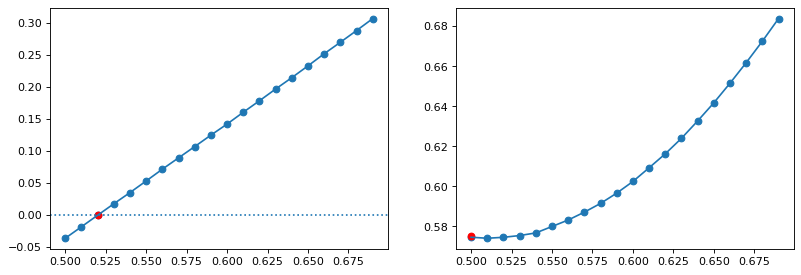

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4), dpi=80, facecolor='w', edgecolor='k')
ax[0].scatter(Hlist,SSTae)
ax[0].plot(Hlist,SSTae)
ax[0].scatter(0.52,0,c = 'red')
ax[0].axhline(y = 0, linestyle = 'dotted')

ax[1].scatter(Hlist,SSTrmse)
ax[1].plot(Hlist,SSTrmse)
ax[1].scatter(0.5,0.575,c = 'red')
#ax[1].axhline(y = 0, linestyle = 'dotted')

In [14]:
#Run with the H that gives a minimum SST abs error
a = 1 #test, leave to 1 for no effect
b = 2
b2 = 1
#H = 0.4045     #For 100m drop and remove profiles shorter than MLD
H = 0.52     #For 500m drop and remove profiles shorter than MLD

mask2 = np.where(ds['k_pred'].data<H, ds['k_pred'], 1)
ds = ds.assign(variables={"k_pred2": (('N_PROF', 'depth'), mask2)})
mask3 = np.where((ds['k_pred']>H) & (ds['k_pred']<b2), a*(b-ds['k_pred']).data, ds['k_pred2'].data)
ds = ds.assign(variables={"k_pred3": (('N_PROF', 'depth'), mask3)})

ds_adj05 = convective_adjustment(ds,mask = ds['k_pred2'])
out = convective_adjustment(ds,mask = ds['k_pred3']).load()


In [15]:
#Retrieve with NaN instead of 0
temp = np.where(out.TEMP_adj.data==0, np.nan, out.TEMP_adj.data)
out = out.assign(variables={"temp_adj": (('N_PROF', 'depth'), temp.data)})
psal = np.where(out.PSAL_adj.data==0, np.nan, out.PSAL_adj.data)
out = out.assign(variables={"psal_adj": (('N_PROF', 'depth'), psal.data)})
sig = np.where(out.PSAL_adj.data==0, np.nan, out.SIG_adj.data)
out = out.assign(variables={"sig_adj": (('N_PROF', 'depth'), sig.data)})

temp = np.where(out.TEMP_INTERP.data==0, np.nan, out.TEMP_INTERP.data)
out = out.assign(variables={"temp": (('N_PROF', 'depth'), temp.data)})
psal = np.where(out.PSAL_INTERP.data==0, np.nan, out.PSAL_INTERP.data)
out = out.assign(variables={"psal": (('N_PROF', 'depth'), psal.data)})
sig = np.where(out.PSAL_INTERP.data==0, np.nan, out.SIG.data)
out = out.assign(variables={"sig": (('N_PROF', 'depth'), sig.data)})

#Compute MLD_adj
sig_diff = out.sig_adj - out.sig_adj.sel(depth = 10)-0.03
MLD = out['depth'].where(sig_diff>0).min(dim='depth')
out = out.assign(MLD_adj = MLD)

In [16]:
out.to_netcdf('/home/datawork-lops-bluecloud/osnet/data_out/PRED_alldepth_bathy500_full_adj.nc')

In [ ]:
#RMSE SST versus TEMP
print('TEMP RMSE obs :' + str(np.around(np.sqrt(((np.fabs(out.SST-out.temp.isel(depth = 0)) ** 2).mean(axis=0))).data,3)))
print('TEMP RMSE pred :' + str(np.around(np.sqrt(((np.fabs(out.SST-out.temp_pred.isel(depth = 0)) ** 2).mean(axis=0))).data,3)))
print('TEMP RMSE adjusted under MLD too :' + str(np.around(np.sqrt(((np.fabs(out.SST-out.temp_adj.isel(depth = 0)) ** 2).mean(axis=0))).data,3)))

In [ ]:
print('TEMP Mean error obs :' + str(np.around((out.SST-out.temp.isel(depth = 0)).mean(axis=0).data,4)))
print('TEMP Mean error pred :' + str(np.around((out.SST-out.temp_pred.isel(depth = 0)).mean(axis=0).data,4)))
print('TEMP Mean adjusted under MLD too :' + str(np.around((out.SST-out.temp_adj.isel(depth = 0)).mean(axis=0).data,4)))


In [ ]:
#Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,4), dpi=80, facecolor='w', edgecolor='k')
sns.kdeplot(out.SST-out.temp.isel(depth = 0),label = 'observed',color = 'orange')
sns.kdeplot(out.SST-out.temp_pred.isel(depth = 0),label = 'predicted',color = 'blue')
sns.kdeplot(out.SST-out.temp_adj.isel(depth = 0),label = 'adjusted ($K^{*}$)',color = 'green')
plt.legend(loc = "upper right")
plt.xlim([-2,2])
plt.title('a)',loc = 'left')
plt.xlabel('SST- surface temperature')
plt.grid()
#plt.savefig(pathfig + 'TS_diff_adj.png', transparent=False)

In [ ]:
#RMSE profile with and without adjustment 
ae_S = np.fabs(out['psal']- out['psal_pred'])
ae_T = np.fabs(out['temp']- out['temp_pred'])
ae_Sadj05 = np.fabs(out['psal']- ds_adj05['PSAL_adj'])
ae_Tadj05 = np.fabs(out['temp']- ds_adj05['TEMP_adj'])
ae_Sadj = np.fabs(out['psal']- out['PSAL_adj'])
ae_Tadj = np.fabs(out['temp']- out['TEMP_adj'])

#Plot of thget_modelal RMSE
def rmse_from_ae(ae):
    return np.sqrt(((ae) ** 2).mean(axis=0))

dmax = -1000
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
ax[0].plot(rmse_from_ae(ae_T), -out['depth'], label='predicted',color = 'blue')
ax[0].plot(rmse_from_ae(ae_Tadj05), -out['depth'], label='adjusted 0.5',color = 'red')
ax[0].plot(rmse_from_ae(ae_Tadj), -out['depth'], label='adjusted under MLD too',color = 'green')
ax[0].set_xlabel('CT [C]')
ax[0].grid()
ax[0].legend(loc='lower right')
ax[0].set_ylim([dmax,10])

ax[1].plot(rmse_from_ae(ae_S), -out['depth'],color = 'blue')
ax[1].plot(rmse_from_ae(ae_Sadj05), -out['depth'],color = 'red')
ax[1].plot(rmse_from_ae(ae_Sadj), -out['depth'],color = 'green')
ax[1].set_xlabel('SA [psu]')
ax[1].grid()
ax[1].set_ylim([dmax,10])

In [ ]:
#Distribution of MLD plot
sig_diff = out.SIG - out.SIG.isel(depth = 10)-0.03
MLD_obs = out['depth'].where(sig_diff>0).min(dim='depth')
out = out.assign(MLD_obs = MLD_obs)
#
sig_diff = out.SIG_predicted - out.SIG_predicted.isel(depth = 10)-0.03
MLD_pred = out['depth'].where(sig_diff>0).min(dim='depth')
out = out.assign(MLD_pred = MLD_pred)
#
sig_diff = out.SIG_adj - out.SIG_adj.isel(depth = 10)-0.03
MLD_adj = out['depth'].where(sig_diff>0).min(dim='depth')
out = out.assign(MLD_adj = MLD_adj)
#
sig_diff = ds_adj05.SIG_adj - ds_adj05.SIG_adj.isel(depth = 10)-0.03
MLD_adj05 = ds_adj05['depth'].where(sig_diff>0).min(dim='depth')
ds_adj05 = ds_adj05.assign(MLD_adj05 = MLD_adj05)
#
#COMPUTE DIFFERENCE BETWEEN OBS AND PRED MLD
diff_pred = out.MLD-out.MLD_pred
diff_adj = out.MLD-out.MLD_adj
diff_shi = out.MLD-out.MLD_adj+4
#
MLD_rmse_pred = np.sqrt((diff_pred**2).mean()).round().data
MLD_rmse_adj = np.sqrt((diff_adj**2).mean()).round().data
MLD_rmse_shi = np.sqrt((diff_shi**2).mean()).round().data

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
sns.kdeplot(out.MLD,label = "observed",ax = ax,color = 'orange')
sns.kdeplot(out.MLD_pred,label = "predicted (" + str(MLD_rmse_pred),ax = ax,color = 'blue')
sns.kdeplot(ds_adj05.MLD_adj05,label = "adjusted 0.5",ax = ax,color = 'red')
sns.kdeplot(out.MLD_adj,label = "adjusted (" + str(MLD_rmse_adj),ax = ax,color = 'green')
sns.kdeplot(out.MLD_adj-4,label = "adjusted + shifted (" + str(MLD_rmse_shi),ax = ax,color = 'green',linestyle = 'dotted')
plt.xlim([0,200])
plt.legend(loc = 'best')
plt.grid()

In [ ]:
#N_prof_max = out.where(out.MLD>600,drop = True).N_PROF.data
#N_prof_max = out.where((out.MLD>80) & (out.MLD<100),drop = True).N_PROF.data[0:20]
#N_prof_max = out.where(out.depth_prof<150,drop = True).N_PROF.data[0:10]
N_prof_max = out.where((out.longitude<-65) & (out.latitude>47),drop = True).N_PROF.data[0:20]


In [ ]:
for i in N_prof_max:
    prof = out.isel(N_PROF = i)
    dmax = -prof.depth_prof.data-10
#    prof05 = ds_adj05.isel(N_PROF = i)
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')

#    ax[0].plot(prof05['TEMP_adj'], -prof['depth'], label='adjusted 0.5',color = 'red')
    ax[0].plot(prof['temp_adj'], -prof['depth'], label='adjusted',color = 'green')
    ax[0].plot(prof['temp_pred'], -prof['depth'], label='predicted',color = 'blue')
    ax[0].plot(prof['temp'], -prof['depth'], label='obs',color = 'orange')
    ax[0].set_ylabel('Depth')
    ax[0].set_xlabel('Temperature')
    ax[0].grid()
    ax[0].set_ylim(dmax,10)
    ax[0].axhline(y = -prof.MLD_obs, color = 'orange')
    ax[0].axhline(y = -prof.MLD_pred, color = 'red', linestyle = 'dotted')
#    ax[0].axhline(y = -prof05.MLD_adj05, color = 'red', linestyle = 'dotted')
    ax[0].axhline(y = -prof.MLD_adj, color = 'green', linestyle = 'dotted')

#    ax[1].plot(prof05['PSAL_adj'], -prof['depth'], label='adjusted 0.5',color = 'red')
    ax[1].plot(prof['psal_adj'], -prof['depth'], label='adjusted',color = 'green')
    ax[1].plot(prof['psal_pred'], -prof['depth'], label='predicted',color = 'blue')
    ax[1].plot(prof['psal'], -prof['depth'], label='obs',color = 'orange')
    ax[1].axhline(y = -prof.MLD_obs, color = 'orange')
    ax[1].axhline(y = -prof.MLD_pred, color = 'red', linestyle = 'dotted')
#    ax[1].axhline(y = -prof05.MLD_adj05, color = 'red', linestyle = 'dotted')
    ax[1].axhline(y = -prof.MLD_adj, color = 'green', linestyle = 'dotted')
    ax[1].set_xlabel('Salinity')
    ax[1].grid()
    ax[1].set_ylim(dmax,10)
    ax[1].set_title('lon=' + str(np.around(prof.longitude.data, decimals=2)) + ' , lat=' + str(np.around(prof.latitude.data, decimals=2)) + 
                ' (' + str(pd.to_datetime(prof.time.data).date()) + ')')


#    ax[2].plot(prof05['SIG_adj'], -prof['depth'], label='adjusted 0.5',color = 'red')
    ax[2].plot(prof['sig'], -prof['depth'], label='observed',color = 'orange')
    ax[2].plot(prof['sig_pred'], -prof['depth'], label='predicted',color = 'blue')
    ax[2].plot(prof['sig_adj'], -prof['depth'], label='adjusted',color = 'green')
    ax[2].axhline(y = -prof.MLD_obs, color = 'orange')
    ax[2].axhline(y = -prof.MLD_pred, color = 'red', linestyle = 'dotted')
#    ax[2].axhline(y = -prof05.MLD_adj05, color = 'red', linestyle = 'dotted')
    ax[2].axhline(y = -prof.MLD_adj, color = 'green', linestyle = 'dotted')
    ax[2].set_xlabel('sigma0')
    ax[2].grid()
    ax[2].legend(loc='best')
    ax[2].set_ylim(dmax,10)


    ax[3].plot(prof['k_pred'], -prof['depth'], label='mask',color = 'blue')
    ax[3].plot(prof['k_pred2'], -prof['depth'], label='mask',color = 'red')
    ax[3].plot(prof['k_pred3'], -prof['depth'], label='mask2',color = 'green')
    ax[3].grid()
    ax[3].set_ylim(dmax,10)

In [ ]:
ae_T0 =  (out.temp_adj.isel(depth = 0)-out.temp_pred.isel(depth = 0))

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)
te = ax.scatter(ds.longitude,ds.latitude,c = ae_T0,cmap = cmocean.cm.balance,vmin = -5,vmax = 5, s = .2)
cbar = plt.colorbar(te, ax=ax, shrink=0.7)
ax.set_title('Surface temperature error between observed and predicted')

ax.add_feature(land_feature, edgecolor='black')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

